In [8]:
import sys
import numpy as np
import cv2

import torchvision
import torchvision.transforms as transforms

sys.path.append('..')
from  utils.TartanDataset import TartanData


# Define the transformation to apply to the images
im_size = 512
transform = transforms.Compose([
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor()
])
a = TartanData("/home/datasets/SLAM/TartainAir",32,transform=transform,d_divider=5)

to_pil = torchvision.transforms.ToPILImage()
videodims = (512,512)
fourcc = cv2.VideoWriter_fourcc(*'MP4V')    
video = cv2.VideoWriter("test.mp4",fourcc, 20,videodims)

data = a.__getitem__(0)

for i in data[0]:
    imtemp = to_pil(i)
    video.write(cv2.cvtColor(np.array(imtemp), cv2.COLOR_RGB2BGR))
video.release()

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


pass 0


In [ ]:
import numpy as np  
import matplotlib.pyplot as plt  
import mpl_toolkits.mplot3d 
import pandas as pd 
 
df = data[1]
X = df[:, 0, 3] 
Y = df[:, 1, 3] 
Z = df[:, 2, 3] 
 
fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d') 
# ax.plot(X, Y, Z, color='white', alpha=0.5) 
ax.scatter(X, Y, Z, c='red') 
plt.show()

tensor(2.282436e-15, dtype=torch.float64)


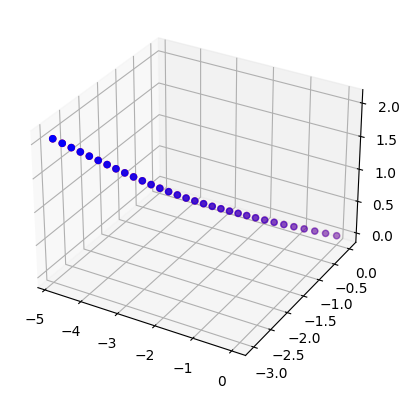

In [20]:
from utils.loss import ape
import torch
rot = torch.tensor([    [0.0000000,  0.0000000,  1.0000000,0],
                        [0.0000000, -1.0000000, -0.0000000,0],
                        [1.0000000,  0.0000000,  0.0000000,0],
                        [0.0000000,  0.0000000,  0.0000000,1],
                         ], dtype=float)
cd = torch.clone(data[1])
cd[:,:3,3]+=10
cd= rot@cd
# cd = torch.tensor(cd)#, requires_grad=True)
r, a,b = ape(data[1],cd,align=True,correct_scale=False,return_res=True)
print(r)
df = a
X = df[:, 0, 3] 
Y = df[:, 1, 3] 
Z = df[:, 2, 3] 

df = b
X1 = [i[0, 3] for i in df]
Y1 = [i[1, 3] for i in df]
Z1 = [i[2, 3] for i in df]
 
 
fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d') 
# ax.plot(X, Y, Z, color='white', alpha=0.5) 
ax.scatter(X, Y, Z, c='red') 
ax.scatter(X1, Y1, Z1, c='blue') 
plt.show()

## Test Loss function

tensor(0.883526, dtype=torch.float64)


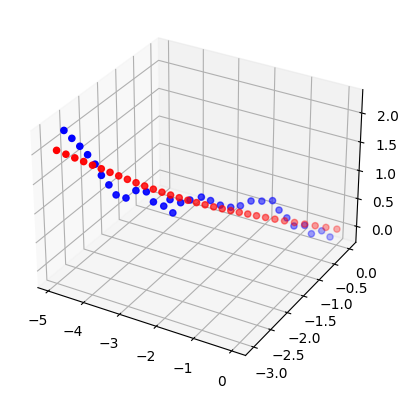

In [15]:
from utils.d3_1.loss import find_poses

P_ = find_poses(data[0]).detach()

# cd = torch.tensor(cd)#, requires_grad=True)
r, a,b = ape(data[1],P_,align=True,correct_scale=True,return_res=True)
print(r)
df = a
X = df[:, 0, 3] 
Y = df[:, 1, 3] 
Z = df[:, 2, 3] 

df = b
X1 = [i[0, 3] for i in df]
Y1 = [i[1, 3] for i in df]
Z1 = [i[2, 3] for i in df]
 
 
fig = plt.figure() 
ax = fig.add_subplot(111, projection='3d') 
# ax.plot(X, Y, Z, color='white', alpha=0.5) 
ax.scatter(X, Y, Z, c='red') 
ax.scatter(X1, Y1, Z1, c='blue') 
plt.show()


In [27]:
import time 
import torch
from utils.loss import ape

K = np.array([[320 , 0 , 320],
              [0 , 320 , 240],
              [0 ,  0  , 1  ]])
              
def pose_matches(im,im1):#, prev_kp,prev_desc):
    orb = cv2.ORB_create()
    # find the keypoints and descriptors with SIFT
    # if prev_desc
    kp1, des1 = orb.detectAndCompute(im,None)
    kp2, des2 = orb.detectAndCompute(im1,None)
    pts1 = []
    pts2 = []

    kp = 0
    # kp1, des1 = orb.detectAndCompute(image, None)
    # kp2, des2 = orb.detectAndCompute(image1, None)
    try:
      matcher = cv2.BFMatcher()
      matches = matcher.match(des1,des2)

      for m in matches[:100]:
          pts2.append(kp2[m.trainIdx].pt)
          pts1.append(kp1[m.queryIdx].pt)
      # for i,(m,n) in enumerate(matches):
      #   if m.distance < 0.8*n.distance:
      #     pts2.append(kp2[m.trainIdx].pt)
      #     pts1.append(kp1[m.queryIdx].pt)

      pts1 = np.int32(pts1)
      pts2 = np.int32(pts2)
      
      # compute relative R,t between ref and cur frame
      E, mask = cv2.findEssentialMat(pts1, pts2,cameraMatrix=K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
      _, R, t, mask = cv2.recoverPose(E, pts1, pts2, cameraMatrix=K)
      P = np.eye(4)
      P[:3,:3] = R
      P[:3,3:] = t

 
    except Exception as e:
        print(e)
        P = np.eye(4)
        # if len(pts1)==0:
        #   pts1 = [0]
        # kpts2 = []


    return P

def find_poses(images):
  images = images.permute(0,2,3,1)
  device = images.device
  # images = ((images/torch.max(images)).cpu().detach().numpy()*255).astype(np.uint8)
  images = ((images).cpu().detach().numpy()*255).astype(np.uint8)
  poses = [np.eye(4)]
  for i in range(len(images)-1):
    image = images[i]
    image1 = images[i+1]
    pose = pose_matches(image,image1)
    poses.append(poses[-1]@pose)
  # images = ((images/torch.max(images)).cpu().detach().numpy()*255).astype(np.uint8)

  return torch.tensor(np.array(poses),dtype=torch.float32,requires_grad=True).to(device)
class timer:
  def start(self):
    self.st = time.time()
  def end(self,c=0):
    print(f"T{c}: ", 1/(time.time()-self.st))

t = timer() 
'''
def find_poses(images):
  t1 = timer()
  t1.start()
  images = images.permute(0,2,3,1)
  device = images.device
  # images = ((images/torch.max(images)).cpu().detach().numpy()*255).astype(np.uint8)
  images = ((images).cpu().detach().numpy()*255).astype(np.uint8)
  poses = [np.eye(4)]
  t1.end(3.1)
  for i in range(len(images)-1):
    image = images[i]
    image1 = images[i+1]
    pose = pose_matches(image,image1)
    poses.append(poses[-1]@pose)
  # images = ((images/torch.max(images)).cpu().detach().numpy()*255).astype(np.uint8)

  return torch.tensor(np.array(poses),dtype=torch.float32,requires_grad=True).to(device)
'''
a = TartanData("/home/datasets/SLAM/TartainAir",32,transform=transform)

t.start()
image_batches = a.__getitem__(100)
t.end(1)
# if b_s == -1:
#   b_s = len(images)

t.start()
images, labels = image_batches[0], image_batches[1]
t.end(2)

# Calculate the number of ORB features detected in the output images
t.start()
P_ = find_poses(images)
t.end(3)

# Calculate the loss based on the number of ORB features
t.start()
loss1 =  ape(labels,P_,True,True)
t.end(4)

T1:  1.805610072455938
T2:  309.679858239811
T3:  0.3882311364721437
T4:  180.47003141000818


In [50]:
from torch.utils.data import DataLoader
import tqdm
t1 = timer()
dataloader = DataLoader(a, shuffle=True, num_workers=8)
t1.start()
for i in dataloader:
    t1.end()
    time.sleep(0.5)
    t1.start()

/home/ashesham/anaconda3/envs/tensorrt/lib/python3.9/site-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


KeyboardInterrupt: 

In [25]:
query_img_bw = np.array(image_batches[0][0].permute(1,2,0))*255
train_img_bw = np.array(image_batches[0][1].permute(1,2,0))*255
# Initialize the ORB detector algorithm
orb = cv2.ORB_create()
   
# Now detect the keypoints and compute
# the descriptors for the query image
# and train image
queryKeypoints, queryDescriptors = orb.detectAndCompute(query_img_bw,None)
trainKeypoints, trainDescriptors = orb.detectAndCompute(train_img_bw,None)
  
# Initialize the Matcher for matching
# the keypoints and then match the
# keypoints
matcher = cv2.BFMatcher()
matches = matcher.match(queryDescriptors,trainDescriptors)
   
# draw the matches to the final image
# containing both the images the drawMatches()
# function takes both images and keypoints
# and outputs the matched query image with
# its train image
# final_img = cv2.drawMatches(query_img_bw.astype(np.uint8), queryKeypoints, 
# train_img_bw.astype(np.uint8), trainKeypoints, matches[:20],None)
   
# final_img = cv2.resize(final_img, (1000,650))
  
# # Show the final image
# cv2.imshow("Matches", final_img)
# cv2.waitKey(3000)

error: OpenCV(4.7.0) /io/opencv/modules/core/src/batch_distance.cpp:274: error: (-215:Assertion failed) type == src2.type() && src1.cols == src2.cols && (type == CV_32F || type == CV_8U) in function 'batchDistance'


In [21]:
pts2=[]
pts1=[]
for m in matches[:100]:
    pts2.append(trainKeypoints[m.trainIdx].pt)
    pts1.append(queryKeypoints[m.queryIdx].pt)

In [51]:
a.__len__()

108912